# Vsebina projektne naloge

Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [389]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from scipy.stats import boxcox
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [390]:
df = pd.read_csv('data/RV2_UPP_IIR_SIPIA.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values(by="Date", inplace=True)

In [391]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
72,2023-02-15 19:35:00+00:00,46.5592,15.656191,270.0,47.0,47.0,0,56.0
78,2023-02-15 20:15:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
79,2023-02-15 20:35:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
153,2023-02-15 21:15:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0
154,2023-02-15 21:35:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0


In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 72 to 3844
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       5625 non-null   datetime64[ns, UTC]
 1   Latitude   5625 non-null   float64            
 2   Longitude  5625 non-null   float64            
 3   Altitude   5625 non-null   float64            
 4   NO2        5339 non-null   float64            
 5   PM2.5      5160 non-null   float64            
 6   O3         5625 non-null   int64              
 7   PM10       5159 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 395.5 KB


# Predprocesiranje podatkov

Zapolnjevanje manjkajočih vrednosti 

In [393]:
df.isnull().sum()

Date           0
Latitude       0
Longitude      0
Altitude       0
NO2          286
PM2.5        465
O3             0
PM10         466
dtype: int64

In [394]:
cols_to_fill = df.columns[df.isnull().any()].tolist()
print(cols_to_fill)

['NO2', 'PM2.5', 'PM10']


In [395]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [396]:
df.isnull().sum()

Date         0
Latitude     0
Longitude    0
Altitude     0
NO2          0
PM2.5        0
O3           0
PM10         0
dtype: int64

# Informations gain

In [397]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5        1.473245
NO2          0.553118
O3           0.010233
Altitude     0.002014
Latitude     0.001333
Longitude    0.001244
Name: Information Gain Scores, dtype: float64

<Axes: >

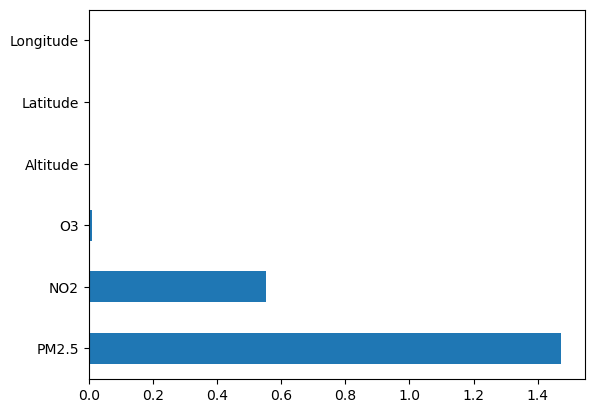

In [398]:
feature_importances.head(10).plot.barh()

Transformacija podatkov

In [399]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()


/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

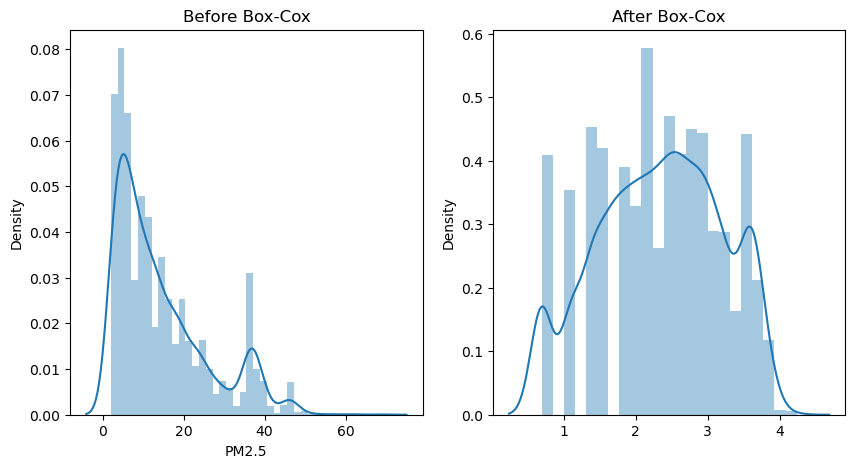

In [400]:
boxcox_transform('PM2.5')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

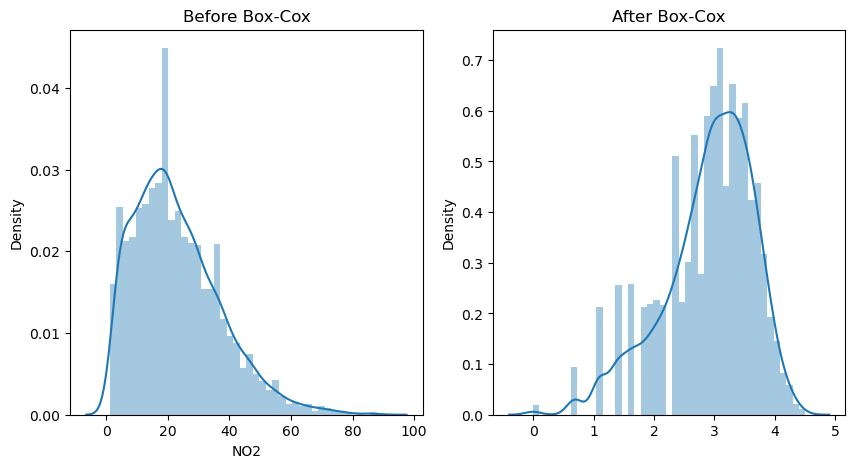

In [401]:
boxcox_transform('NO2')

Normalizacija podatkov

In [402]:
columns_to_normalize = ['PM2.5', 'NO2']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Izdelava modela

In [403]:
target_variable = 'PM10'
features = ['PM2.5', 'NO2']
selected_features = features + [target_variable]
data = df[selected_features]

In [404]:
def create_time_series(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length]
        sequences.append(np.array(sequence))
    return np.array(sequences)

In [405]:
sequence_length = 7

In [406]:
sequences = create_time_series(data, sequence_length)

In [407]:
train_size = int(len(sequences) * 0.8)
train_data = sequences[:train_size]
test_data = sequences[train_size:]

In [408]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(features))))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [409]:
model.fit(train_data[:, :, :-1], train_data[:, -1, -1], epochs=10, batch_size=32)

predictions = model.predict(test_data[:, :, :-1])

test_target = test_data[:, -1, -1]
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)
r2 = r2_score(test_target, predictions)

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

Epoch 1/10
141/141 [==============================] - 1s 2ms/step - loss: 416.4211
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 225.5425
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 180.8736
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 120.4146
Epoch 5/10
141/141 [==============================] - 0s 2ms/step - loss: 94.6236
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 79.2949
Epoch 7/10
141/141 [==============================] - 0s 2ms/step - loss: 69.4770
Epoch 8/10
141/141 [==============================] - 0s 2ms/step - loss: 61.4389
Epoch 9/10
141/141 [==============================] - 0s 2ms/step - loss: 58.2519
Epoch 10/10
36/36 [==============================] - 0s 677us/step
MAE: 5.977439753425159, MSE: 63.62705894203837, R^2: 0.5676573029161236
